# IMPORT MODULES

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
#from keras.models import load_model
import keras.backend as k1
from sklearn.model_selection import train_test_split
from skimage.io import imread,imshow
from skimage.transform import resize
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D,Convolution2D,AveragePooling2D,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121,DenseNet169

#from keras.applications.densenet import preprocess_input
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from glob import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Data Read

In [2]:
path='Data/'
l=glob(path+"*")
s=len(glob(path+"*"))
print(l)

['Data\\Healthy', 'Data\\Unhealthy']


# Data Extraction

In [3]:
path='Data/'
l=glob(path+"*")
s=len(glob(path+"*"))
extract=[]
name_items=[]
for i in l:
    name_items.append(i[5:])
print(name_items)

flat_data_arr=[] #input array
target_arr=[] #output array
for j in name_items:
    m=glob(path+j+"/*")
    for h in m:
        s = cv2.imread(h, cv2.IMREAD_COLOR) 
        try:      
            s= cv2.resize(s, (224,224))
            s= cv2.cvtColor(s, cv2.COLOR_BGR2RGB)
        except:
          break
        extract.append([np.array(s),j])
print(len(extract))
ex=extract

['Healthy', 'Unhealthy']
1221


# Labelling the Images

In [4]:
import os
from PIL import Image

# Define the paths to the folders
healthy_folder = 'Data/Healthy/'
unhealthy_folder = 'Data/Unhealthy/'

# Define empty lists for data and labels
data = []
labels = []

# Loop over the healthy folder
for image_path in os.listdir(healthy_folder):
    # Read the image and convert it to numpy array
    try:
      image = Image.open(os.path.join(healthy_folder, image_path)).convert('RGB')
      # Check image shape and resize if necessary
      if image.size != (224, 224):
        image = image.resize((224, 224))
    # Append the image to the data list and the label to the labels list
      data.append(np.array(image))
      labels.append(0)
    except:
      break

# Loop over the unhealthy folder
for image_path in os.listdir(unhealthy_folder):
    # Read the image and convert it to numpy array
    try:
      image = Image.open(os.path.join(unhealthy_folder, image_path)).convert('RGB')
      # Check image shape and resize if necessary
      if image.size != (224, 224):
        image = image.resize((224, 224))
    # Append the image to the data list and the label to the labels list
      data.append(np.array(image))
      labels.append(1)
    except:
      break

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)
# Reshape data array to have a shape of (num_samples, height, width, channels)
data = data.reshape(data.shape[0], 224, 224, 3)

# Display the Labelled Images

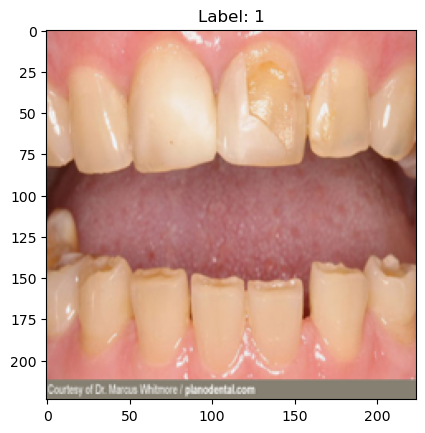

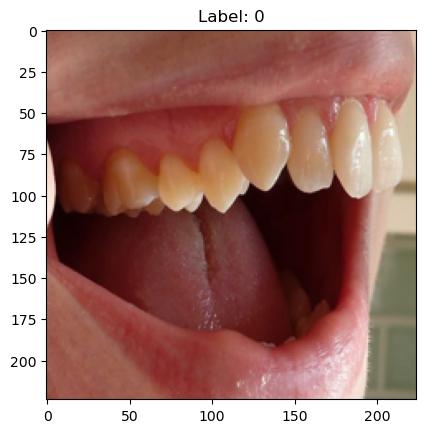

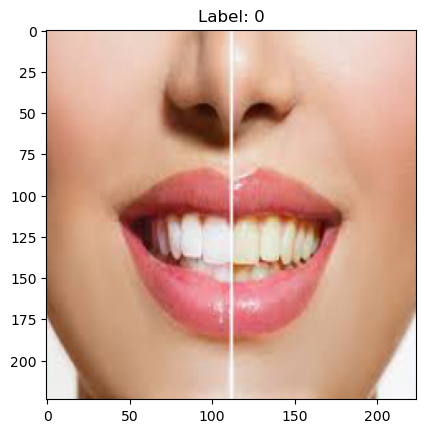

In [25]:
import matplotlib.pyplot as plt

# Print the first 3 images along with their labels
for i in range(3):
    plt.imshow(data[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()


In [6]:
data.shape

(1221, 224, 224, 3)

# Using Image Augmentation

In [95]:
from keras.preprocessing.image import ImageDataGenerator

# Shuffle the data and labels together
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # only rescale pixel values for validation set

# Define batch size and number of epochs
batch_size = 32
epochs = 30

# Create the data generators for training and validation sets
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

# Inception V3 Model

In [96]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Define input shape
input_shape = (224, 224, 3)

# Load InceptionV3 pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 256 hidden units and ReLU activation
x = Dense(256, activation='relu')(x)

# Add a final softmax layer for classification
predictions = Dense(2, activation='softmax')(x)

# Define the model to train
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the Model

In [98]:
# Train the model
history = model.fit_generator(train_generator, 
                    epochs=epochs, 
                    steps_per_epoch=x_train.shape[0] // batch_size, 
                    validation_data=val_generator, 
                    validation_steps=x_val.shape[0] // batch_size)

C:\Users\Nikita\AppData\Local\Temp\ipykernel_10688\1247330181.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
30/30 [==============================] - 56s 2s/step - loss: 0.8606 - accuracy: 0.5233 - val_loss: 0.4789 - val_accuracy: 0.5714
Epoch 2/30
30/30 [==============================] - 46s 2s/step - loss: 0.4621 - accuracy: 0.5508 - val_loss: 0.4376 - val_accuracy: 0.5759
Epoch 3/30
30/30 [==============================] - 46s 2s/step - loss: 0.4093 - accuracy: 0.5646 - val_loss: 0.4574 - val_accuracy: 0.4955
Epoch 4/30
30/30 [==============================] - 46s 2s/step - loss: 0.4147 - accuracy: 0.5593 - val_loss: 0.4240 - val_accuracy: 0.5357
Epoch 5/30
30/30 [==============================] - 45s 1s/step - loss: 0.3712 - accuracy: 0.5583 - val_loss: 0.4169 - val_accuracy: 0.5580
Epoch 6/30
30/30 [==============================] - 45s 2s/step - loss: 0.3999 - accuracy: 0.5519 - val_loss: 0.4153 - val_accuracy: 0.5491
Epoch 7/30
30/30 [==============================] - 46s 2s/step - loss: 0.3415 - accuracy: 0.5625 - val_loss: 0.4399 - val_accuracy: 0.6027
Epoch 8/30
30/30 [==

# Save the Model

In [123]:
model.save('my_inc_model.h5')

# Histogram

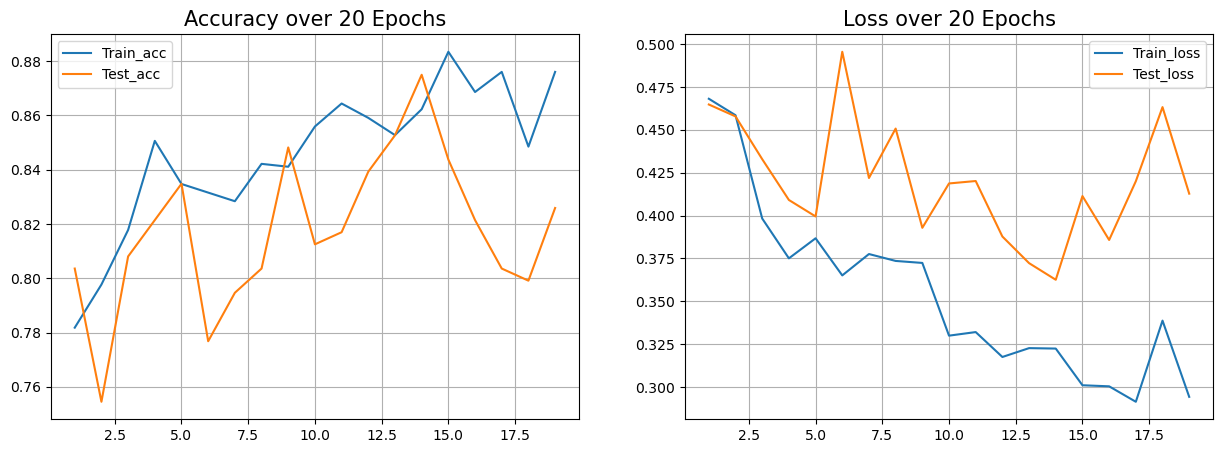

In [45]:
import matplotlib.pyplot as plt
def plot_acc_loss(results, epochs):
    acc = results.history['accuracy']
    loss = results.history['loss']
    val_acc = results.history['val_accuracy']
    val_loss = results.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
plot_acc_loss(history, epochs)

# Load the Model

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('my_inc_model.h5')

# Testing 

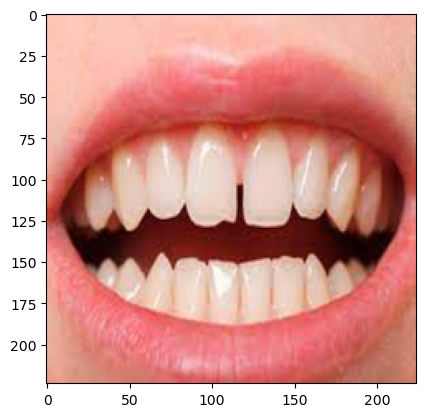

1/1 [==============================] - 0s 168ms/step
5.4729047e-31
Healthy


In [124]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image and convert it to numpy array
image = Image.open('l.jpeg').convert('RGB')
if image.size != (224, 224):
    image = image.resize((224, 224))
image_array = np.array(image).reshape((1, 224, 224, 3))

# Display the image
plt.imshow(image)
plt.show()

# Make a prediction on the image
prediction = model.predict(image_array)
print(prediction[0][0])
if prediction[0][0] > 0.5:
    print('Unhealthy')
else:
    print('Healthy')

m.jpg,
n.jpeg,
g.png,
i.jpg,
j.jpg 
shows correct result here.

**e.jpg,
f.jpg,
h.jpg
shows wrong results here.